In [ ]:
#note: for this to work you need to create a symbolic link to the fastai/old/fastai folder in the fastai github repo:
# in administrator mode, navigate to this folder in the comand prompt then type the following command 
# $ mklink /d fastai "C:\Users\Dean Procter\_github\fastai\old\fastai" <<<---- path of fastai\old\fastai 

#e.g. https://forums.fast.ai/t/howto-installation-on-windows/10439
#e.g. https://superuser.com/questions/1020821/how-to-create-a-symbolic-link-on-windows-10

## Image classification with Convolutional Neural Networks

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

`PATH` is the path to your data - if you use the recommended setup approaches from the lesson, you won't need to change this. `sz` is the size that the images will be resized to in order to ensure that the training runs quickly. We'll be talking about this parameter a lot during the course. Leave it at `224` for now.

In [4]:
sz=224

It's important that you have a working NVidia GPU set up. The programming framework used to behind the scenes to work with NVidia GPUs is called CUDA. Therefore, you need to ensure the following line returns `True` before you proceed. If you have problems with this, please check the FAQ and ask for help on [the forums](http://forums.fast.ai).

In [5]:
torch.cuda.is_available()

True

In addition, NVidia provides special accelerated functions for deep learning in a package called CuDNN. Although not strictly necessary, it will improve training performance significantly, and is included by default in all supported fastai configurations. Therefore, if the following does not return `True`, you may want to look into why.

In [6]:
torch.backends.cudnn.enabled

True

In [7]:
import os
#this notebook file should be in your main experiment folder, the training folder (with valid, train and test subfolders) should be in this main experiment folder. 
#List the names you've given the following folders below
training_folder = "training2"
#os.mkdir(training_folder)
MAIN_PATH = os.getcwd()
PATH = os.path.join(MAIN_PATH,training_folder)
#os.mkdir(os.path.join(PATH,"_manuallysorted"))

# now put your CNNexport folder into the training folder

In [8]:
os.listdir(PATH)

['117_20190707_H3K9me3quant_repL_v2CNNexport',
 'models',
 'tmp',
 'train',
 'valid',
 '_manuallysorted']

In [9]:
test_subfolder = "117_20190707_H3K9me3quant_repL_v2CNNexport"
model_name = test_subfolder[0:-10] #because we are creating our own model 
TEST_PATH = os.path.join(PATH, test_subfolder)
print(TEST_PATH)

G:\117\117_20190707_H3K9me3quant_repKrepL\_pipeline\v2\training2\117_20190707_H3K9me3quant_repL_v2CNNexport


In [10]:
files = os.listdir(TEST_PATH)

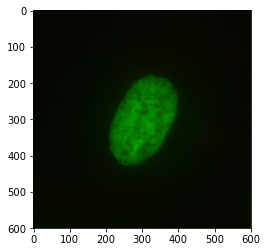

In [11]:
img = plt.imread(f'{TEST_PATH}\\{files[0]}')
img
plt.imshow(img);

Here is how the raw data looks like

# train the model

In [12]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1) #CHANGED AUGMENTATIONS FROM transforms_side_on

In [13]:
#it is probably easier to just mklink to this 
# e.g. mklink /d 117_20190603_SUN1vLaminAC_repA_v1A_CNNexport "G:\117\117_20190603_laminAC_timecourse\_slidescan\_pipeline\v1A\117_20190603_SUNvLaminAC_repA_v1A_CNNexport"
### ACTUALLYIT SEEMS LIKE IT WORKS BEST PHYSICALLY IN THE SAME FOLDER
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name=test_subfolder)

In [14]:
arch=resnet34

In [15]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [16]:
#sometimes this fails, just run it again... this usually fixes it! Consider it like priming the pump!
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 282/282 [03:58<00:00,  3.42it/s]


In [17]:
learn.fit(1e-2, 1)


epoch      trn_loss   val_loss   accuracy   
    0      0.505734   0.147281   0.952133  


[0.14728060522883293, 0.9521331945889698]

In [18]:
learn.precompute=False

In [19]:
learn.fit(1e-2, 5, cycle_len=3)


epoch      trn_loss   val_loss   accuracy   
    0      0.189602   0.11311    0.965661  
    1      0.16823    0.100815   0.966701  
    2      0.156626   0.098244   0.967742  
    3      0.141966   0.089916   0.972945  
    4      0.121771   0.081593   0.976067  
    5      0.116371   0.082013   0.977107  
    6      0.110368   0.074588   0.977107  
    7      0.104864   0.071264   0.975026  
    8      0.100985   0.07005    0.975026  
    9      0.102229   0.064312   0.980229  
    10     0.09623    0.064262   0.980229  
    11     0.090539   0.062313   0.98231   
    12     0.088431   0.060052   0.980229  
    13     0.079938   0.059863   0.98127   
    14     0.07812    0.057837   0.98127   


[0.05783732612224821, 0.9812695109261186]

### Fine-tuning and differential learning rate annealing

In [20]:
learn.unfreeze()

In [21]:
lr=np.array([1e-4,1e-3,1e-2])

In [22]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=3)


epoch      trn_loss   val_loss   accuracy   
    0      0.282659   0.091773   0.962539  
    1      0.135981   0.024031   0.996878  
    2      0.081176   0.017068   0.994797  
    3      0.058305   0.016614   0.994797  
    4      0.043004   0.012636   0.996878  
    5      0.03847    0.012739   0.993757  
    6      0.029344   0.01938    0.995838  
    7      0.021958   0.008725   0.997919  
    8      0.019038   0.009874   0.996878  
    9      0.016356   0.007475   0.995838  
    10     0.017359   0.007865   0.996878  
    11     0.017132   0.006663   0.997919  
    12     0.024293   0.006731   0.998959  


[0.006730521010558637, 0.9989594172736732]

In [23]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [24]:
accuracy_np(probs, y)

1.0

In [25]:
learn.save(model_name)

In [26]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

A common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [27]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[275   0   0   0   0]
 [  0 236   0   0   0]
 [  0   0   2   0   0]
 [  0   0   0 202   0]
 [  0   0   0   0 246]]


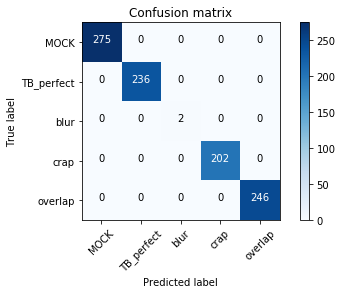

In [28]:
plot_confusion_matrix(cm, data.classes)

In [29]:
#most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
#plot_val_with_title(most_uncertain, "Most uncertain predictions")

# PREDICTIONS

In [30]:
learn.load(model_name)

In [31]:
#skipped, perhaps can delete
#learn.precompute=False

In [32]:
preds = learn.predict(is_test = True)

In [33]:
test_files = data.test_dl.dataset.fnames

In [34]:
preds

array([[ -0.00091, -12.29935,  -7.04653, -10.32343, -15.38023],
       [ -0.00139, -11.78199,  -6.64068,  -9.6523 , -11.34327],
       [ -0.01688,  -6.25058,  -5.36776,  -4.62979,  -7.84875],
       ...,
       [ -0.00501, -10.83789,  -7.44584, -11.25593,  -5.42964],
       [ -0.02607, -10.18414,  -6.64998,  -7.92156,  -3.7279 ],
       [ -0.00005, -15.57852,  -9.89908, -14.17806, -13.78644]], dtype=float32)

In [35]:
#test_files

In [36]:
learn.precompute=False

In [37]:
#show me the classes in our model
data.classes

['MOCK', 'TB_perfect', 'blur', 'crap', 'overlap']

In [38]:
#show me the filenames in our test dataset
#data.test_ds.fnames

In [39]:
# get prediction on the test dataset rather than validation dataset
log_preds, y = learn.TTA(is_test=True) 

In [40]:
probs = np.mean(np.exp(log_preds),0)

In [41]:
probs.shape

(18006, 5)

In [42]:
df = pd.DataFrame(probs)
df.columns = data.classes

In [43]:
df.insert(0, 'id', [o for o in data.test_ds.fnames])
#df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames])

In [44]:
df.head()

,id,MOCK,TB_perfect,blur,crap,overlap
0,117_20190707_H3K9me3quant_repL_v2CNNexport\117...,0.997593,0.000014,0.002192,0.000200,7.047981e-07
1,117_20190707_H3K9me3quant_repL_v2CNNexport\117...,0.999374,0.000011,0.000544,0.000068,3.041609e-06
2,117_20190707_H3K9me3quant_repL_v2CNNexport\117...,0.949804,0.001993,0.006105,0.041727,3.712408e-04
3,117_20190707_H3K9me3quant_repL_v2CNNexport\117...,0.418561,0.001115,0.005932,0.570734,3.657728e-03
4,117_20190707_H3K9me3quant_repL_v2CNNexport\117...,0.000387,0.000120,0.002654,0.996811,2.841277e-05


In [45]:
#strip prefix from filename to match UNIQUE ID
CNN_export_folder = test_subfolder
df["id"].replace(regex=True,inplace=True,to_replace=CNN_export_folder + '\\\\',value='')
df["id"].replace(regex=True,inplace=True,to_replace='.jpg',value='') #or coud cut with [0:-4] in df.insert above

In [46]:
df.head()

,id,MOCK,TB_perfect,blur,crap,overlap
0,117_20190707_repL_96hpi_1000_1_RGB,0.997593,0.000014,0.002192,0.000200,7.047981e-07
1,117_20190707_repL_96hpi_1000_2_RGB,0.999374,0.000011,0.000544,0.000068,3.041609e-06
2,117_20190707_repL_96hpi_1000_3_RGB,0.949804,0.001993,0.006105,0.041727,3.712408e-04
3,117_20190707_repL_96hpi_1000_4_RGB,0.418561,0.001115,0.005932,0.570734,3.657728e-03
4,117_20190707_repL_96hpi_1000_5_RGB,0.000387,0.000120,0.002654,0.996811,2.841277e-05


In [47]:
probs_csv_name = CNN_export_folder + "_usingMODEL_" + model_name + ".csv"
df.to_csv(probs_csv_name, index=False)

In [48]:
#START HERE IF YOU DON'T WANT TO DO THE PREDICTIONS AGAIN
import pandas as pd
import sys
import os
from os import listdir
import shutil
import datetime

In [49]:
#uncomment this to load csv
#df = pd.read_csv("117_20190112_v1Ca_CNN_predictions.csv")

In [50]:
#let's check that our data looks good
df.head()

,id,MOCK,TB_perfect,blur,crap,overlap
0,117_20190707_repL_96hpi_1000_1_RGB,0.997593,0.000014,0.002192,0.000200,7.047981e-07
1,117_20190707_repL_96hpi_1000_2_RGB,0.999374,0.000011,0.000544,0.000068,3.041609e-06
2,117_20190707_repL_96hpi_1000_3_RGB,0.949804,0.001993,0.006105,0.041727,3.712408e-04
3,117_20190707_repL_96hpi_1000_4_RGB,0.418561,0.001115,0.005932,0.570734,3.657728e-03
4,117_20190707_repL_96hpi_1000_5_RGB,0.000387,0.000120,0.002654,0.996811,2.841277e-05


In [51]:
df_cnn_pred = df
total_cells = str(df_cnn_pred.shape[0])
print("Number of cells in full dataset: "+ total_cells)
cat_labels = df_cnn_pred.columns[1:]
print("Classification labels:")
for x in cat_labels:
    print("-->"+ x)

Number of cells in full dataset: 18006
Classification labels:
-->MOCK
-->TB_perfect
-->blur
-->crap
-->overlap


In [52]:
#### TRY TO ADD A PROGRESS BAR TO THIS AS IT CAN TAKE QUITE SOME TIME ###
#e.g. https://github.com/tqdm/tqdm#ipython-jupyter-integration

#just copy the path for now from the folder used as TEST
#### TRY TO REMOVE THE NECESSITY OF THIS DEFINITION AS IT IS ALREADY DEFINED ABOVE
#test_folder_path = f'{PATH}\\{CNN_export_folder}'
test_folder_path = TEST_PATH
confidence_cutoff_values = [0.99,0.90,0.80,0.70,0.60,0.50]

foldername = "CNNpredictions_" + datetime.datetime.now().strftime('%Y%m%d_%H%M')
mydir = os.path.join(os.getcwd(), foldername)
os.makedirs(mydir)

for cutoff_val in confidence_cutoff_values:
    
    def label_cat (row):
        if row['MOCK'] >= cutoff_val :
          return 'MOCK'
        if row['TB_perfect'] >= cutoff_val :
          return 'TB_perfect'
        if row['blur'] >= cutoff_val :
          return 'blur'
        if row['crap'] >= cutoff_val :
          return 'crap'
        if row['overlap'] >= cutoff_val :
          return 'overlap'
        #if row['TB_early'] >= cutoff_val :
        #  return 'TB_early'
        return 'FALSE'
    
    colname = str(int(cutoff_val*100)) + "confidence"
    df_cnn_pred['cnnsort_cat'] = df_cnn_pred.apply (lambda row: label_cat (row),axis=1)
    df_cnn_pred_sort = df_cnn_pred[df_cnn_pred.cnnsort_cat != "FALSE"]    
    proportion_of_dataset = 100 - (int(total_cells) - int(df_cnn_pred_sort.shape[0]))/int(total_cells)*100
    
    print("\rSorting for {}% confidence, representing {}% of the total dataset".format(cutoff_val*100,int(proportion_of_dataset)), end="", flush=True)

    cat_val = df_cnn_pred_sort.cnnsort_cat.unique()
    cat_val = df_cnn_pred_sort.cnnsort_cat.unique()
    for cats in cat_val:
        os.makedirs(os.path.join(mydir,colname,cats))
    
    list_fn=[]
    #### THIS DOESNT WORK 
    #this will scan through the training dataset and only add files that aren't in the training dataset to the CNN predictions, comment this out if you want these
    #for r,d,f in os.walk(test_folder_path):
        #for file in f:
         #   list_fn.append(file)    
    ######
    
    #this will scan through the higher confidence folders and only add files that are unique to the lower datasets
    for r,d,f in os.walk(mydir):
        for file in f:
            list_fn.append(file) 
    
    for index, rows in df_cnn_pred_sort.iterrows():
        fn = rows.id + ".jpg"
        if fn not in list_fn:
            cnnsort_cat = rows.cnnsort_cat
            new_filename = os.path.join(mydir, colname , cnnsort_cat, fn)
            old_filename = os.path.join(test_folder_path, fn)
            shutil.copy(old_filename, new_filename)
    
    

Sorting for 50.0% confidence, representing 94% of the total dataset

In [43]:
import smtplib, ssl

port = 465  # For SSL
smtp_server = "smtp.gmail.com"
sender_email = "USERNAME@gmail.com" # Enter your address
password = "PASSWORD"
#password = input("Type your password and press enter: ")

receiver_email = "RECEIVER_EMAIL_ADDRESS@gmail.com"  # Enter receiver address

message = f"""\
Subject: {CNN_export_folder} pipeline complete

This message is sent from Python."""

context = ssl.create_default_context()
with smtplib.SMTP_SSL(smtp_server, port, context=context) as server:
    server.login(sender_email, password)
    server.sendmail(sender_email, receiver_email, message)